In [ ]:
# pip install xgboost

In [ ]:
# pip install shap

In [1]:
import pandas as pd
import numpy as np
import os
import tqdm
import shap
import time
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve,auc,roc_auc_score,confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score,brier_score_loss,precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE,RFECV

# 复合结局

In [2]:
os.chdir("/Users/weiyuna/Desktop/工作/合作项目/上海胸科/20211103导出数据/房颤/补充结局-不包含瓣膜手术")

In [3]:
data = pd.read_csv("data_imputation_full.csv")

In [4]:
data.columns[2:5]

Index(['outcome', 'outcome_h', 'outcome_b'], dtype='object')

In [5]:
data.columns[5:65]

Index(['AF_category', 'Gender', 'Age', 'BMI', 'HR', 'DBP', 'SBP', 'LVESD',
       'LVEDD', 'LAD', 'LVEF', 'HF', 'HAS_BLED', 'CHA_2DS_2-VACs', 'TSH',
       'FBG', 'UA', 'TT', 'PTINR', 'CREA', 'Ccr', 'DD', 'TnI', 'LDH', 'AST',
       'ALB', 'GLU', 'CK', 'NT-pro-BNP', 'Aspirin', 'Clopidogrel',
       'Other.antiplatelet.agents', 'Antiplatelet.agents', 'Warfarin',
       'Dabigatran', 'Rivaroxaban', 'Heparin', 'Anticoagulants', 'Statins',
       'ACEI_ARB', 'β.blocker', 'Diuretics', 'CCB', 'Antihypertensive.agents',
       'Ever.smoking', 'Ever.drinking', 'Angina', 'Heart.failure', 'Stroke',
       'PAD', 'COPD', 'Hypertension', 'Diabetes', 'Hyperlipidemia', 'MI',
       'CHD', 'CKD', 'Prior.RFA', 'Prior.PCI', 'Prior.CABG'],
      dtype='object')

In [6]:
features_outcome = data.columns[2:5]

In [7]:
features_include = data.columns[5:65]

In [8]:
X = data[features_include]
Y = data[features_outcome]

In [9]:
## 随机拆分训练集和验证集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=123, stratify=Y)

In [10]:
Y1_train = Y_train["outcome"]
Y2_train = Y_train["outcome_h"]
Y3_train = Y_train["outcome_b"]
Y1_test = Y_test["outcome"]
Y2_test = Y_test["outcome_h"]
Y3_test = Y_test["outcome_b"]

In [11]:
Y1_test.value_counts()

0    991
1     19
Name: outcome, dtype: int64

# grid search cv

In [121]:
rf_cv_parameters = {'n_estimators':[50,100,200,300], # 4
                    'criterion':['gini', 'entropy', 'log_loss'],  #3
                    'max_depth':[3,5,7,10], # 4
                    'min_samples_split':[2,5,10,20,50], # 5
                    'min_samples_leaf':[2,5,10,20,50], # 5
                    'max_features':[5,7,10,15,20], # 5
                   'random_state':[123]}

st = time.time()
rf = RandomForestClassifier()
rf_gs1 = GridSearchCV(rf, param_grid = rf_cv_parameters,cv=3, n_jobs=-1,scoring="roc_auc")
rf_gs1.fit(X_train,Y1_train)

# 性能测评
print("参数的最佳取值：:", rf_gs1.best_params_)
print("最佳模型得分:", rf_gs1.best_score_)
et = time.time()
print("耗时: {} s".format(et-st))


6000 fits failed out of a total of 18000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6000 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_o

参数的最佳取值：: {'criterion': 'gini', 'max_depth': 7, 'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 50, 'n_estimators': 100, 'random_state': 123}
最佳模型得分: 0.7341498363288247
耗时: 22825.09233403206 s


In [12]:
rf1 = RandomForestClassifier(criterion='gini',max_depth=7,max_features=5,min_samples_leaf=5,min_samples_split=50,
                           n_estimators=100,random_state=123).fit(X_train,Y1_train)

In [13]:
explainer1 = shap.TreeExplainer(rf1)
shap_values1 = explainer1(X_train)

In [14]:
shap_values1.values[:,:,1].shape

(2355, 60)

In [47]:
a = X_train.columns.values

In [64]:
df = pd.DataFrame(shap_values1.values[:,:,1])

In [65]:
df.columns = X_train.columns

In [76]:
X_train["Age"]

3143    65
695     59
966     71
3141    74
1601    73
        ..
2265    73
2312    65
1119    51
2752    59
873     62
Name: Age, Length: 2355, dtype: int64

In [67]:
df["Age"]

0      -0.000803
1      -0.000428
2      -0.000519
3      -0.000417
4      -0.000052
          ...   
2350   -0.001625
2351   -0.000285
2352   -0.000498
2353   -0.000692
2354   -0.000475
Name: Age, Length: 2355, dtype: float64

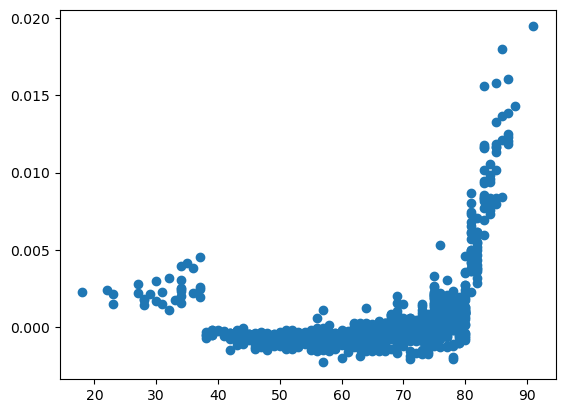

In [88]:
plt.scatter(X_train["Age"],df["Age"])

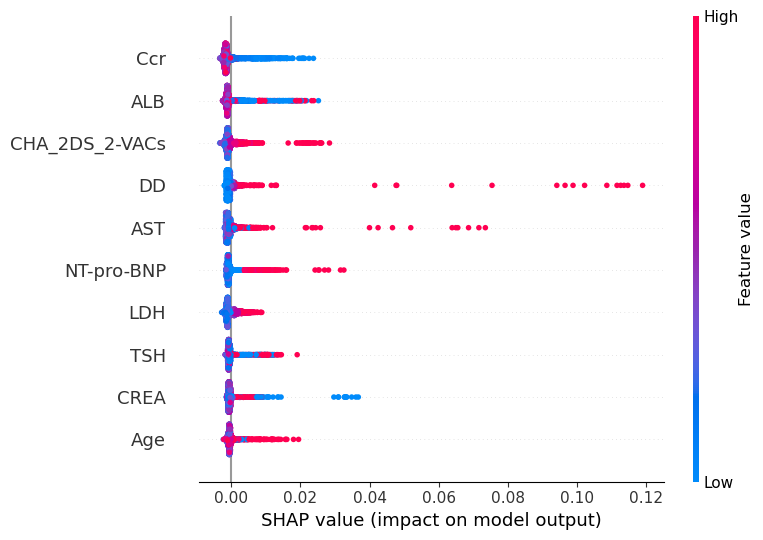

In [15]:
fig = plt.figure(figsize=(10,10))
shap.summary_plot(shap_values1.values[:,:,1],X_train,plot_type="dot",max_display=10,show=False)
# plt.savefig("RF_shap_outcome.pdf",dpi=300)

In [114]:
def plot_shap_scatter(shap_value,df,feature_name):
    df_shap = pd.DataFrame(shap_value.values[:,:,1])
    df_shap.columns = df.columns 
    x = df[feature_name]
    y = df_shap[feature_name]
    if feature_name in ['NT-pro-BNP']:
        plt.xscale("log",base=10)
        plt.xticks([0,10,100,1000,10000],[0,10,100,1000,10000])
#         plt.xlim([0,12500])
    if feature_name in ['CREA']:
        plt.xlim([0,300])
    plt.scatter(x,y,marker="+",linewidth=0.8,c=x)
    plt.xlabel(feature_name)
    plt.ylabel("SHAP value")
    plt.colorbar()

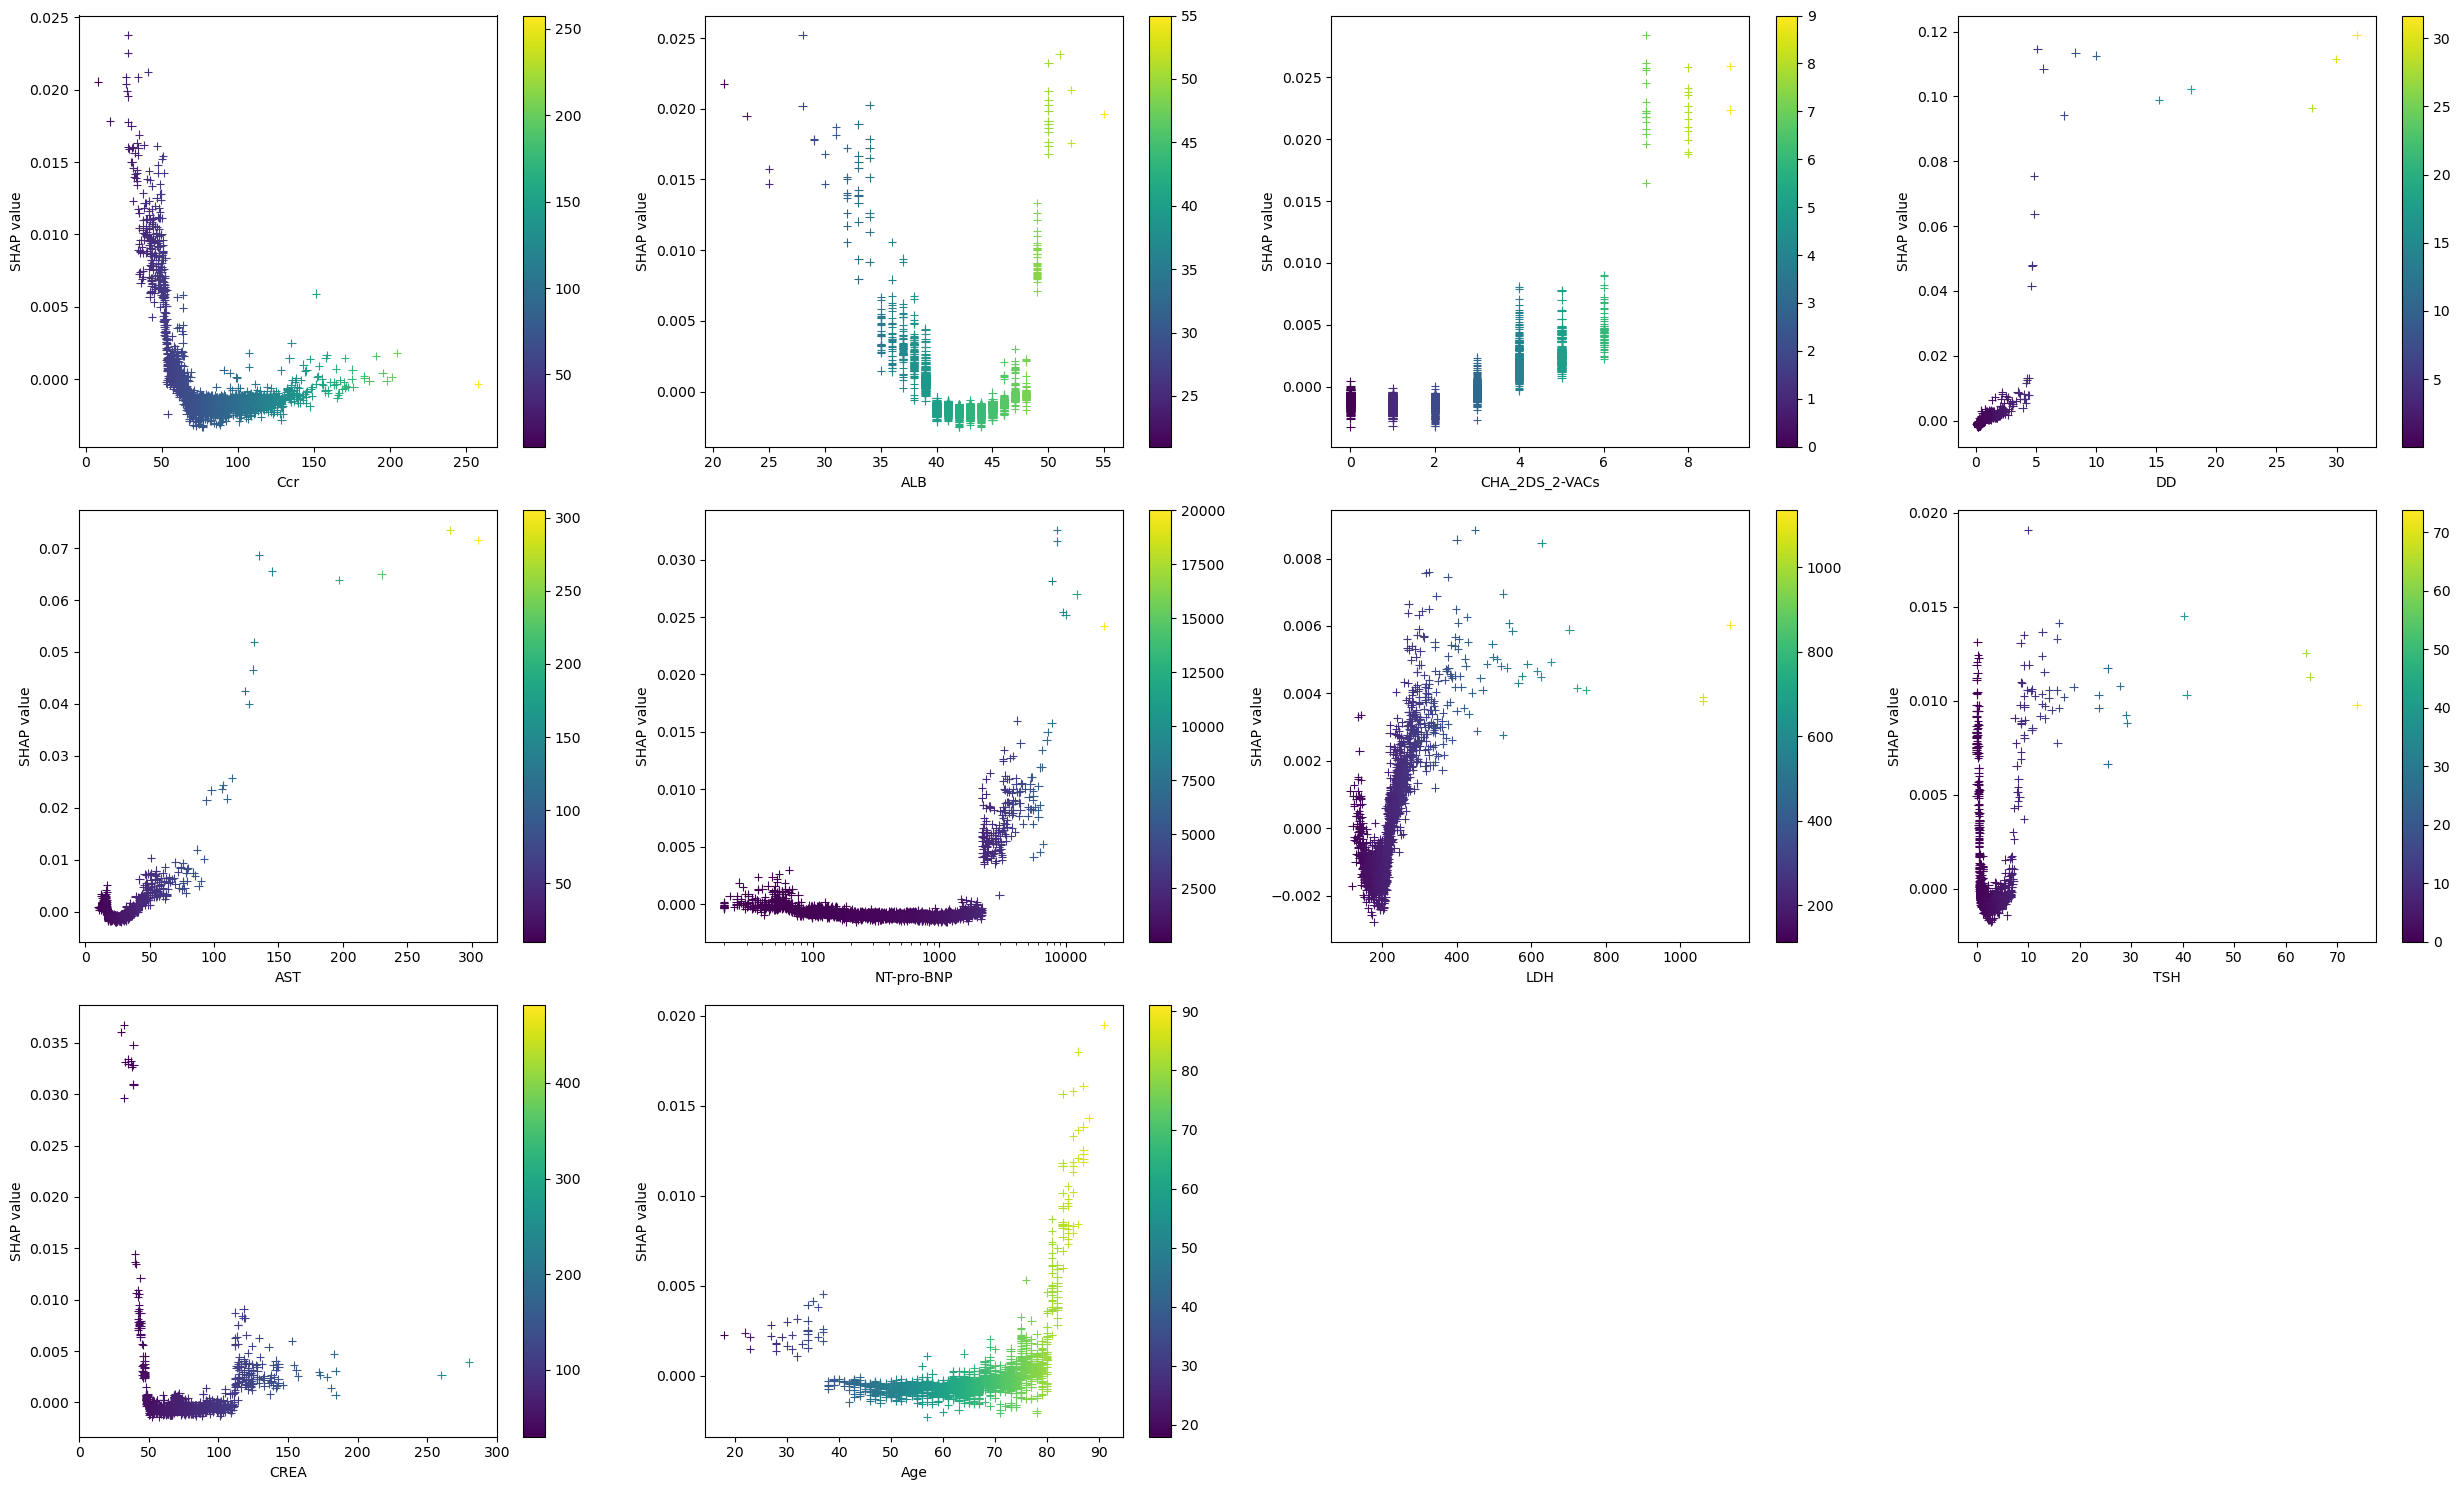

In [116]:
feature_list = ['Ccr', 'ALB', 'CHA_2DS_2-VACs', 'DD', 'AST', 'NT-pro-BNP', 'LDH','TSH', 'CREA', 'Age']

plt.figure(figsize=(25,15))
for i in range(len(feature_list)):
    plt.subplot(3,4,i+1)
    plot_shap_scatter(shap_values1,X_train,feature_list[i])
plt.tight_layout()
plt.savefig("RF_shap_scatter_outcome.pdf",dpi=300)

In [16]:
def get_shap_top_n(shap_value,n):
    fea_imp = pd.DataFrame()
    fea_imp["feature_name"] = X_train.columns
    fea_imp["shap_value"] = np.sum(np.abs(shap_value.values[:,:,1]),axis=0)
    fea_imp.sort_values("shap_value",ascending=False,inplace=True)
    return fea_imp[0:n].feature_name.values

In [17]:
def get_shap_values(shap_value):
    fea_imp = pd.DataFrame()
    fea_imp["feature_name"] = X_train.columns
    fea_imp["shap_value"] = np.sum(np.abs(shap_value.values[:,:,1]),axis=0)
    fea_imp.sort_values("shap_value",ascending=False,inplace=True)
    return fea_imp

In [18]:
# get_shap_values(shap_values1).to_csv("rf1_shap.csv")
# get_shap_values(shap_values2).to_csv("rf2_shap.csv")
# get_shap_values(shap_values3).to_csv("rf3_shap.csv")

In [19]:
get_shap_top_n(shap_values1,10)

array(['Ccr', 'ALB', 'CHA_2DS_2-VACs', 'DD', 'AST', 'NT-pro-BNP', 'LDH',
       'TSH', 'CREA', 'Age'], dtype=object)

In [122]:
rf_cv_parameters = {'n_estimators':[50,100,200,300], # 4
                    'criterion':['gini', 'entropy', 'log_loss'],  #3
                    'max_depth':[3,5,7,10], # 4
                    'min_samples_split':[2,5,10,20,50], # 5
                    'min_samples_leaf':[2,5,10,20,50], # 5
                    'max_features':[5,7,10,15,20], # 5
                   'random_state':[123]}

rf_gs2 = GridSearchCV(rf, param_grid = rf_cv_parameters,cv=3, n_jobs=-1,scoring="roc_auc")
rf_gs2.fit(X_train,Y2_train)

# 性能测评
print("参数的最佳取值：:", rf_gs2.best_params_)
print("最佳模型得分:", rf_gs2.best_score_)
et = time.time()
print("耗时: {} s".format(et-st))


6000 fits failed out of a total of 18000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6000 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_o

参数的最佳取值：: {'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123}
最佳模型得分: 0.798406501760284
耗时: 28871.742319107056 s


In [20]:
rf2 = RandomForestClassifier(criterion='gini',max_depth=10,max_features=7,min_samples_leaf=10,min_samples_split=2,
                           n_estimators=100,random_state=123).fit(X_train,Y2_train)

In [21]:
explainer2 = shap.TreeExplainer(rf2)
shap_values2 = explainer2(X_train)

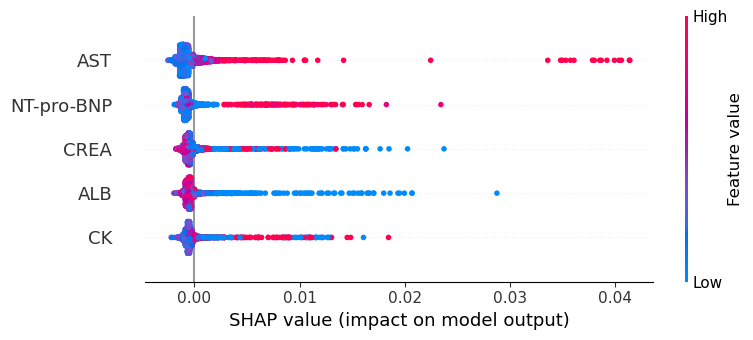

In [22]:
fig = plt.figure(figsize=(10,10))
shap.summary_plot(shap_values2.values[:,:,1],X_train,plot_type="dot",max_display=5,show=False)
# plt.savefig("RF_shap_outcome_h.pdf",dpi=300)

In [23]:
get_shap_top_n(shap_values2,5)

array(['AST', 'NT-pro-BNP', 'CREA', 'ALB', 'CK'], dtype=object)

In [123]:
rf_cv_parameters = {'n_estimators':[50,100,200,300], # 4
                    'criterion':['gini', 'entropy', 'log_loss'],  #3
                    'max_depth':[3,5,7,10], # 4
                    'min_samples_split':[2,5,10,20,50], # 5
                    'min_samples_leaf':[2,5,10,20,50], # 5
                    'max_features':[5,7,10,15,20], # 5
                   'random_state':[123]}

rf_gs3 = GridSearchCV(rf, param_grid = rf_cv_parameters,cv=3, n_jobs=-1,scoring="roc_auc")
rf_gs3.fit(X_train,Y3_train)

# 性能测评
print("参数的最佳取值：:", rf_gs3.best_params_)
print("最佳模型得分:", rf_gs3.best_score_)
et = time.time()
print("耗时: {} s".format(et-st))


6000 fits failed out of a total of 18000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6000 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_o

参数的最佳取值：: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 10, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 200, 'random_state': 123}
最佳模型得分: 0.8554889847562874
耗时: 33707.53187704086 s


In [24]:
rf3 = RandomForestClassifier(criterion='entropy',max_depth=7,max_features=10,min_samples_leaf=20,min_samples_split=50,
                           n_estimators=200,random_state=123).fit(X_train,Y3_train)

In [25]:
explainer3 = shap.TreeExplainer(rf3)
shap_values3 = explainer3(X_train)

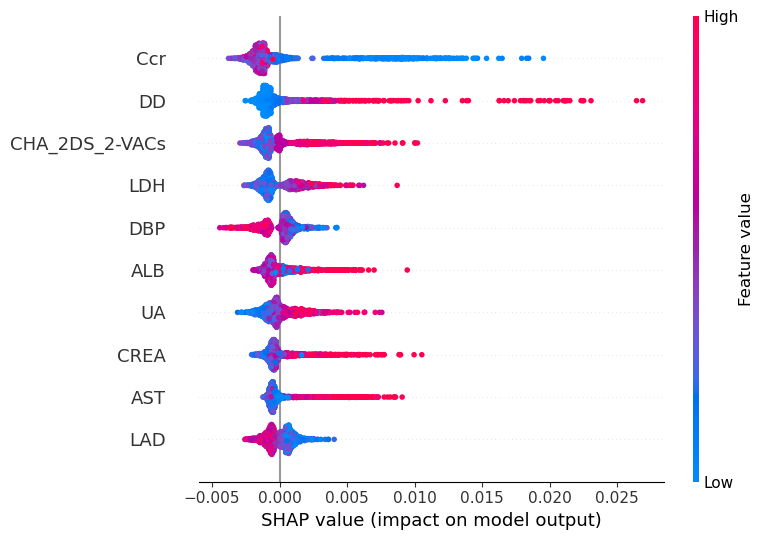

In [26]:
fig = plt.figure(figsize=(10,10))
shap.summary_plot(shap_values3.values[:,:,1],X_train,plot_type="dot",max_display=10,show=False)
# plt.savefig("RF_shap_outcome_b.pdf",dpi=300)

In [27]:
get_shap_top_n(shap_values3,10)

array(['Ccr', 'DD', 'CHA_2DS_2-VACs', 'LDH', 'DBP', 'ALB', 'UA', 'CREA',
       'AST', 'LAD'], dtype=object)